### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, train_test_split_and_balance
from src.data_loader import CustomLabeledImageDataset
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [2]:
# Constants:
DATASET = 'data/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES_PATH = os.path.join(DATASET, 'images/')
LABEL = 'diabetic_retinopathy'
TEST_SIZE = 0.2
UNDERSAMPLE = True

BATCH_SIZE = 32

BACKBONE = 'dinov2_base'
MODE = 'fine_tune'

#### Read csv file:

In [3]:
df = get_dataset("data/", download=DOWNLOAD, info=False)
df.head()

loading csv file in data//labels.csv


,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality,normality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal


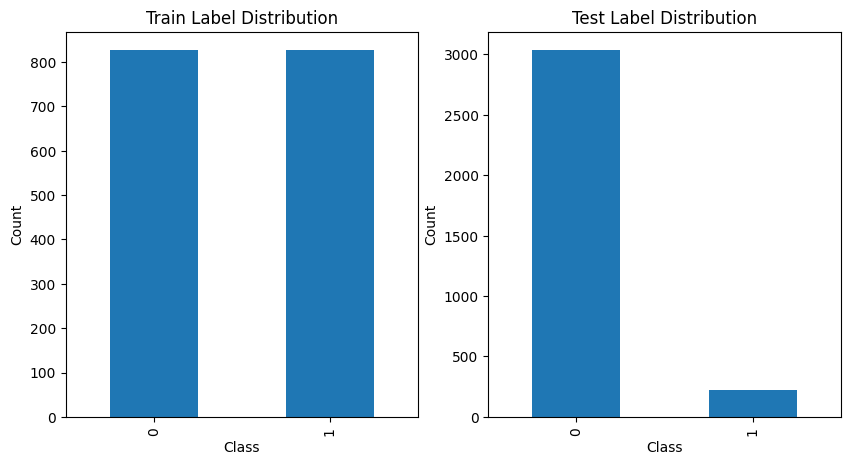

In [4]:
# Usage
df_train, df_test = train_test_split_and_balance(df, LABEL, TEST_SIZE, undersample=UNDERSAMPLE)

### Dataloaders

In [7]:
# Create the custom dataset
train_dataset = CustomLabeledImageDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_train,
    shape=SHAPE,
    transform=None,
    label_col=LABEL
)

test_dataset = CustomLabeledImageDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_test,
    shape=SHAPE,
    transform=None,
    label_col=LABEL
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

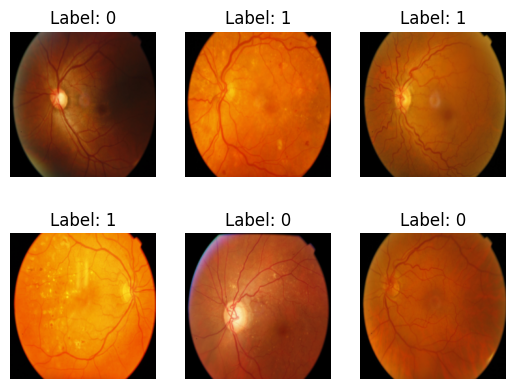

In [8]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:
    images, labels = batch

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [9]:
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, num_classes=2, mode=MODE)
model

Using cache found in /home/datascience/.cache/torch/hub/facebookresearch_dinov2_main


FoundationalCVModelWithClassifier(
  (backbone): FoundationalCVModel(
    (backbone): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_fea

### Training:

In [10]:
# Define your hyperparameters
num_epochs = 10
learning_rate = 0.001

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))  # Ensure labels are tensors and have the right shape
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}')

print('Training finished.')

# Save the trained model if needed
torch.save(model.state_dict(), f'Models/fine_tuned_{BACKBONE}.pth')

### Test

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

model.eval()

# Initialize lists to store true labels and model predictions
true_labels = []
model_predictions = []

eval_images_0 = []
eval_images_1 = []

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Collect true labels and model predictions
        true_labels += labels.tolist()
        model_predictions += predicted.tolist()
        
        # Collect evaluation images with class 0 and 1
        eval_images_0 += [img for i, img in enumerate(images) if labels[i] == 0]
        eval_images_1 += [img for i, img in enumerate(images) if labels[i] == 1]

# Calculate accuracy, AUC, and F1 score
accuracy = accuracy_score(true_labels, model_predictions)
auc = roc_auc_score(true_labels, model_predictions)
f1 = f1_score(true_labels, model_predictions)

print(f'Accuracy on test images: {100 * accuracy}%')
print(f'AUC: {auc}')
print(f'F1 Score: {f1}')

In [ ]:
# Generate Saliency Maps
def get_saliency_map(model, input_image):
    model.eval()
    input_image.requires_grad_()
    output = model(input_image)
    max_idx = output.argmax()
    output[0, max_idx].backward()
    saliency_map, _ = torch.max(input_image.grad.data.abs(),dim=1)
    #saliency_map = input_image.grad.data.abs().max(1)[0]
    return saliency_map

# Select some evaluation images to generate saliency maps
eval_images = eval_images_0[:5] + eval_images_1[:5]

#print(eval_images)

for i, eval_image in enumerate(eval_images):
    eval_image = eval_image.unsqueeze(0)  # Add batch dimension
    saliency_map = get_saliency_map(model, eval_image)

    
    # Plot original image and saliency map side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(eval_image[0].permute(1, 2, 0).detach().numpy())
    plt.title(f'Original Image (Class {labels[i]})')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map[0].detach().numpy(), cmap=plt.cm.hot)
    plt.title('Saliency Map')
    
    plt.tight_layout()
    plt.show()
